# Indice. Cosas hechas

- Preprocesamiento previo
    - Creación de PK
    - Quitamos datos estáticos (`ETA` <2400): check
    - Comprobación PK única
    - Nueva columna `predict_arrival_date`: check
    - Nueva columna `reliable_arrival_date`: FALTA COMPROBAR

- Matriz de correlaciones: casi check but peta

    
- Para cada variable: 
    - Valores nulos. Posibles soluciones
    - Correlaciones con ETA
    - Gráfico según categoría
    - Conclusión. La quitamos o la dejamos




# EDA para una muestra de un día

Seleccionaremos de manera aleatoria un día del mes, para ese día realizaremos un análisis de los datos.

In [1]:
import os
import statistics
import polars as pl
import pandas as pd
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings("ignore")

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))
DATA_PATH = os.path.join(ROOT_PATH, "data", "processed")
EMT_DATA_PATH = os.path.join(DATA_PATH, "emt")


# Leemos los datos 

## Seleccionamos una muestra aleatoria 

In [3]:
import random
random.seed(1234)  
day = random.randint(2, 31)


In [4]:
sample_data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03",str(day), f"emt_202403{str(day)}.csv"))

In [5]:
sample_data.collect()

date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,str,i64,str,i64,f64,f64,i64,i64,str,i64,str,str,i64,i64,bool,str,str,i64
"""2024-03-26""","""2024-03-26 08:…",515,"""27""",29,-3.690684,40.446013,0,1973,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",569
"""2024-03-26""","""2024-03-26 08:…",537,"""27""",29,-3.69115,40.44098,0,2497,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",586
"""2024-03-26""","""2024-03-26 08:…",4851,"""5""",29,-3.689987,40.45582,0,688,"""CHAMARTIN""",0,null,null,null,null,false,null,null,124
"""2024-03-26""","""2024-03-26 08:…",4852,"""5""",29,-3.692056,40.435094,0,3948,"""CHAMARTIN""",0,null,null,null,null,false,null,null,961
"""2024-03-26""","""2024-03-26 08:…",5637,"""147""",29,-3.69001,40.455671,0,710,"""BARRIO DEL PIL…",0,null,null,null,null,false,null,null,157
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-26""","""2024-03-26 22:…",8839,"""171""",51022,0.0,0.0,0,0,"""MAR DE CRISTAL…",0,null,null,null,null,true,null,null,999999
"""2024-03-26""","""2024-03-26 22:…",2063,"""174""",51023,-3.617285,40.482495,0,2144,"""VALDEBEBAS""",0,"""06:00""","""23:45""",7,22,false,"""LA""","""N""",327
"""2024-03-26""","""2024-03-26 22:…",2149,"""174""",51023,-3.670754,40.488775,0,8368,"""VALDEBEBAS""",0,"""06:00""","""23:45""",7,22,false,"""LA""","""N""",1225


# Variables numéricas

In [6]:
sample_data.select(cs.numeric()).head().collect()

bus,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,deviation,MinimunFrequency,MaximumFrequency,estimateArrive
i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
515,29,-3.690684,40.446013,0,1973,0,3,12,569
537,29,-3.69115,40.44098,0,2497,0,3,12,586
4851,29,-3.689987,40.45582,0,688,0,null,null,124
4852,29,-3.692056,40.435094,0,3948,0,null,null,961
5637,29,-3.69001,40.455671,0,710,0,null,null,157


# Variables categóricas

In [7]:
sample_data.select(cs.string()).head().collect()

date,datetime,line,destination,StartTime,StopTime,dayType,strike
str,str,str,str,str,str,str,str
"""2024-03-26""","""2024-03-26 08:…","""27""","""PLAZA CASTILLA…","""05:55""","""23:30""","""LA""","""N"""
"""2024-03-26""","""2024-03-26 08:…","""27""","""PLAZA CASTILLA…","""05:55""","""23:30""","""LA""","""N"""
"""2024-03-26""","""2024-03-26 08:…","""5""","""CHAMARTIN""",null,null,null,null
"""2024-03-26""","""2024-03-26 08:…","""5""","""CHAMARTIN""",null,null,null,null
"""2024-03-26""","""2024-03-26 08:…","""147""","""BARRIO DEL PIL…",null,null,null,null


# Preprocesamiento previo 
## 1. Creamos la PK

In [8]:
sample_data = sample_data.with_columns((pl.col('datetime').cast(pl.String)+"_B"+pl.col('bus').cast(pl.String)+"_L"+ pl.col('line').cast(pl.String)+"_S"+pl.col('stop').cast(pl.String)).alias('PK'))
sample_data.head().collect()

date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive,PK
str,str,i64,str,i64,f64,f64,i64,i64,str,i64,str,str,i64,i64,bool,str,str,i64,str
"""2024-03-26""","""2024-03-26 08:…",515,"""27""",29,-3.690684,40.446013,0,1973,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",569,"""2024-03-26 08:…"
"""2024-03-26""","""2024-03-26 08:…",537,"""27""",29,-3.69115,40.44098,0,2497,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",586,"""2024-03-26 08:…"
"""2024-03-26""","""2024-03-26 08:…",4851,"""5""",29,-3.689987,40.45582,0,688,"""CHAMARTIN""",0,null,null,null,null,false,null,null,124,"""2024-03-26 08:…"
"""2024-03-26""","""2024-03-26 08:…",4852,"""5""",29,-3.692056,40.435094,0,3948,"""CHAMARTIN""",0,null,null,null,null,false,null,null,961,"""2024-03-26 08:…"
"""2024-03-26""","""2024-03-26 08:…",5637,"""147""",29,-3.69001,40.455671,0,710,"""BARRIO DEL PIL…",0,null,null,null,null,false,null,null,157,"""2024-03-26 08:…"


### PK no única

In [9]:
sample_data.group_by(pl.col('PK')).count().sort('count',descending = True).head().collect()

PK,count
str,u32
"""2024-03-26 22:…",2
"""2024-03-26 22:…",2
"""2024-03-26 22:…",2
"""2024-03-26 22:…",2
"""2024-03-26 22:…",2


## 2. Eliminamos los valores incorrectos `estimateArrive` 

In [10]:
sample_data.group_by(pl.col('estimateArrive')).count().sort('estimateArrive',descending=True).head().collect()

estimateArrive,count
i64,u32
999999,2586
888888,292
5395,1
5390,1
5385,1


Filtramos por un ETA < 40 minutos ya que a más tiempo es un valor por defecto poco fiable

In [11]:
sample_data = sample_data.filter(pl.col('estimateArrive')<888888)

### Comprobamos que la PK es única

In [12]:
sample_data.group_by(pl.col('PK')).count().sort('count',descending = True).head().collect()

PK,count
str,u32
"""2024-03-26 21:…",2
"""2024-03-26 22:…",2
"""2024-03-26 13:…",2
"""2024-03-26 19:…",1
"""2024-03-26 21:…",1


Sigue habiendo datos duplicados, por lo que para esos casos, cogeremos el que tenga menor ETA

In [13]:
sample_data = sample_data.group_by('PK').min()

sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,str,str,i64,str,i64,f64,f64,i64,i64,str,i64,str,str,i64,i64,bool,str,str,i64
"""2024-03-26 08:…","""2024-03-26""","""2024-03-26 08:…",5557,"""124""",1489,-3.702846,40.453513,0,1680,"""LACOMA""",0,null,null,null,null,false,null,null,530
"""2024-03-26 11:…","""2024-03-26""","""2024-03-26 11:…",2495,"""173""",3261,-3.688148,40.471312,0,4805,"""SANCHINARRO""",0,"""06:00""","""23:45""",7,21,false,"""LA""","""N""",1035
"""2024-03-26 16:…","""2024-03-26""","""2024-03-26 16:…",8828,"""9""",1846,-3.67174,40.44559,0,3971,"""HORTALEZA""",0,null,null,null,null,false,null,null,1419
"""2024-03-26 21:…","""2024-03-26""","""2024-03-26 21:…",3272,"""11""",224,-3.705294,40.464001,0,5023,"""BARRIO BLANCO""",0,null,null,null,null,false,null,null,1386
"""2024-03-26 21:…","""2024-03-26""","""2024-03-26 21:…",5551,"""42""",1501,-3.695603,40.469574,0,1742,"""BARRIO PEÑAGRA…",0,"""06:00""","""23:45""",7,24,false,"""LA""","""N""",535


In [14]:
sample_data.group_by('PK').count().sort('count',descending=True).head().collect()

PK,count
str,u32
"""2024-03-26 22:…",1
"""2024-03-26 09:…",1
"""2024-03-26 13:…",1
"""2024-03-26 11:…",1
"""2024-03-26 14:…",1


## 3. Matriz de confusión

### Pasamos `datetime` a formato fecha

In [15]:
sample_data = sample_data.with_columns(pl.col('datetime').map_elements(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")))

### Pasamos `date` a formato fecha

In [16]:
sample_data = sample_data.with_columns(pl.col("date").cast(pl.Date))

### Pasamos las variables `bus` y `stop` a categóricas

In [21]:
sample_data = sample_data.with_columns(pl.col('bus').cast(pl.String),pl.col('stop').cast(pl.String))

### Pasamos la variable `isHead` a numérica

In [22]:
sample_data = sample_data.with_columns(pl.col('isHead').cast(pl.UInt8))

In [23]:
sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,date,datetime[μs],str,str,str,f64,f64,i64,i64,str,i64,str,str,i64,i64,u8,str,str,i64
"""2024-03-26 16:…",2024-03-26,2024-03-26 16:43:07.030452,"""115""","""C03""","""72""",-3.692692,40.412195,0,671,"""ARGÜELLES""",0,null,null,null,null,0,null,null,198
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:49:06.056967,"""2591""","""150""","""42""",-3.693005,40.419091,0,3413,"""VIRGEN CORTIJO…",3571,null,null,null,null,0,null,null,658
"""2024-03-26 13:…",2024-03-26,2024-03-26 13:22:08.248714,"""2063""","""174""","""3253""",-3.675717,40.482236,0,4160,"""VALDEBEBAS""",0,"""06:00""","""23:45""",7,22,0,"""LA""","""N""",1062
"""2024-03-26 12:…",2024-03-26,2024-03-26 12:37:06.911218,"""5663""","""40""","""37""",-3.690147,40.454252,0,0,"""ALFONSO XIII""",0,null,null,null,null,0,null,null,0
"""2024-03-26 11:…",2024-03-26,2024-03-26 11:33:09.567141,"""2340""","""135""","""5604""",-3.688159,40.471268,0,182,"""HOSPITAL RAMON…",0,"""06:30""","""23:45""",9,29,1,"""LA""","""N""",229


In [24]:
numeric_var = ['bus', 'line','stop',
 'positionBusLon',
 'positionBusLat',
 'DistanceBus',
 'deviation',
 'MinimunFrequency',
 'MaximumFrequency',
 'isHead',
 'estimateArrive',]

In [25]:
sample_data_df = sample_data.collect()

In [26]:
matrix = [[0] * len(numeric_var) for _ in range(len(numeric_var))]
for i in range(0,len(numeric_var)):
    for j in range(0,len(numeric_var)):
        matrix[i][j] = sample_data_df.select(pl.corr(numeric_var[i],numeric_var[j])).item()

In [27]:
matrix_corr = pd.DataFrame(matrix, columns=numeric_var,index=numeric_var).apply(lambda col: col.round(4))

In [28]:
matrix_corr

,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,deviation,MinimunFrequency,MaximumFrequency,isHead,estimateArrive
bus,1.0000,0.0312,0.0854,0.1903,-0.1960,-0.0502,0.0694,0.0952,0.2754,0.0071,0.0249
line,0.0312,1.0000,0.2475,-0.0336,0.0437,0.2646,-0.1021,0.4368,0.3918,0.0814,0.1255
stop,0.0854,0.2475,1.0000,0.0798,-0.0650,0.0874,-0.0092,0.0138,0.0713,0.2519,0.0247
positionBusLon,0.1903,-0.0336,0.0798,1.0000,-0.9978,0.0604,-0.0187,0.0571,-0.0137,-0.0097,0.0495
positionBusLat,-0.1960,0.0437,-0.0650,-0.9978,1.0000,-0.0541,0.0138,0.0283,0.0365,0.0132,-0.0468
DistanceBus,-0.0502,0.2646,0.0874,0.0604,-0.0541,1.0000,-0.0594,0.2596,0.2147,-0.0762,0.8407
deviation,0.0694,-0.1021,-0.0092,-0.0187,0.0138,-0.0594,1.0000,-0.0119,0.0891,-0.0072,-0.0350
MinimunFrequency,0.0952,0.4368,0.0138,0.0571,0.0283,0.2596,-0.0119,1.0000,0.7845,0.0321,0.3231
MaximumFrequency,0.2754,0.3918,0.0713,-0.0137,0.0365,0.2147,0.0891,0.7845,1.0000,0.0396,0.2558
isHead,0.0071,0.0814,0.2519,-0.0097,0.0132,-0.0762,-0.0072,0.0321,0.0396,1.0000,0.0298


<Axes: >

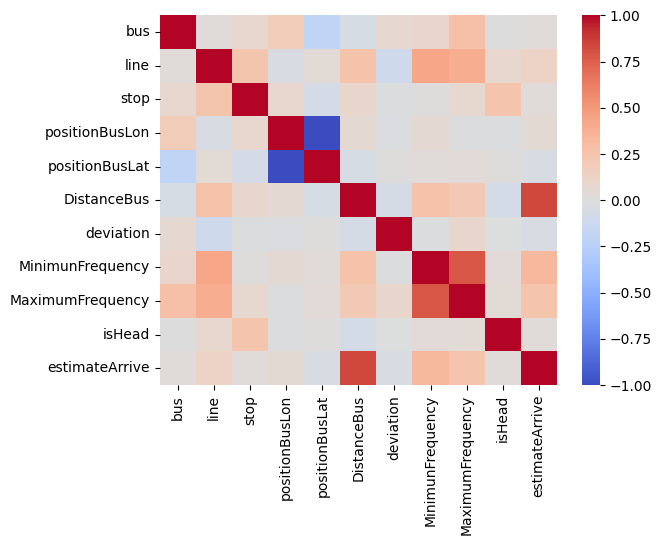

In [29]:
sns.heatmap(matrix_corr, cmap='coolwarm',vmin=-1, vmax=1)

In [30]:
matrix_corr.to_csv('/home/mlia/proyectos/data-generation/docs/notebooks/aux/matrix_corr_emt.csv', index=False)

## 4. Estudio por variables

Para cada variabl:
1. Comprobaremos si tiene valores nulos 
2. Calcularemos la correlación con la variable `estimateArrive`
3. Dibujaremos el tiempo medio de llegada según sus categorías en el caso en el que fuera posible
4. Decidiremos si la mantenemos o la eliminamos

In [31]:
sample_data.head().describe() 

statistic,PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,str,str,str,str,str,str,f64,f64,f64,f64,str,f64,str,str,f64,f64,f64,str,str,f64
"""count""","""5""","""5""","""5""","""5""","""5""","""5""",5.0,5.0,5.0,5.0,"""5""",5.0,"""4""","""4""",4.0,4.0,5.0,"""4""","""4""",5.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""1""","""1""",1.0,1.0,0.0,"""1""","""1""",0.0
"""mean""",null,"""2024-03-26""",null,null,null,null,-3.674766,40.462648,0.0,2016.2,null,0.0,null,null,8.0,20.0,0.2,null,null,772.2
"""std""",null,null,null,null,null,null,0.01451,0.030936,0.0,1708.533055,null,0.0,null,null,3.464102,5.416026,0.447214,null,null,673.764944
"""min""","""2024-03-26 10:…","""2024-03-26""",null,"""2134""","""107""","""1848""",-3.689668,40.42965,0.0,74.0,"""BARRIO CANILLE…",0.0,"""05:55""","""23:30""",3.0,12.0,0.0,"""LA""","""N""",19.0
"""25%""",null,"""2024-03-26""",null,null,null,null,-3.688258,40.437317,0.0,700.0,null,0.0,null,null,9.0,22.0,0.0,null,null,323.0
"""50%""",null,"""2024-03-26""",null,null,null,null,-3.671349,40.467393,0.0,1880.0,null,0.0,null,null,9.0,22.0,0.0,null,null,571.0
"""75%""",null,"""2024-03-26""",null,null,null,null,-3.669843,40.471557,0.0,3271.0,null,0.0,null,null,9.0,22.0,0.0,null,null,1371.0
"""max""","""2024-03-26 21:…","""2024-03-26""",null,"""9118""","""48""","""3870""",-3.654712,40.507321,0.0,4156.0,"""PLAZA CASTILLA…",0.0,"""06:20""","""23:45""",11.0,24.0,1.0,"""LA""","""N""",1577.0


##  Variable `date`

### Valores nulos

In [32]:
sample_data.group_by(pl.col('date')).count().head().collect()

date,count
date,u32
2024-03-26,1136086


## Variable `datetime`

### Valores nulos

In [33]:
sample_data.group_by(pl.col('datetime')).count().head().collect()

datetime,count
datetime[μs],u32
2024-03-26 19:24:06.215955,8
2024-03-26 16:14:06.777800,10
2024-03-26 09:37:07.786371,4
2024-03-26 20:07:06.302297,8
2024-03-26 16:11:06.642268,8


## Varable `bus`

### Valores nulos

In [29]:
sample_data.group_by(pl.col('bus')).count().head().collect()

bus,count
str,u32
"""2263""",46
"""8858""",712
"""2535""",3413
"""4742""",3837
"""5665""",2505


### Correlación

In [30]:
sample_data.select(pl.corr('bus','estimateArrive')).head().collect()

bus
f64
0.025721


### Gráfico

In [31]:
sample_data.group_by(pl.col('bus')).mean().select(pl.col('bus'),pl.col('estimateArrive')).collect().plot.bar(x='bus')

:Bars   [bus]   (estimateArrive)

### Conclusión

Según que autobús sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

## Variable `line`

### Valores nulos

In [32]:
sample_data.group_by(pl.col('line')).count().head().collect()

line,count
str,u32
"""82""",3430
"""48""",13673
"""129""",40389
"""40""",15423
"""178""",34032


### Correlación

In [33]:
sample_data.select(pl.corr('line','estimateArrive')).head().collect()

line
f64
0.122705


### Gráfico

In [34]:
sample_data.group_by(pl.col('line')).mean().select(pl.col('line'),pl.col('estimateArrive')).collect().plot.bar(x='line')

:Bars   [line]   (estimateArrive)

### Conclusión

Según que línea sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

## Variable `stop`

### Valores nulos

In [35]:
sample_data.group_by(pl.col('stop')).count().head().collect()

stop,count
i64,u32
3683,1690
4734,1707
4731,1724
42,8582
134,6831


### Correlación

In [36]:
sample_data.select(pl.corr('stop','estimateArrive')).head().collect()

stop
f64
0.023113


### Gráfico

In [37]:
sample_data.group_by(pl.col('stop')).mean().select(pl.col('stop'),pl.col('estimateArrive')).collect().plot.bar(x='stop')

:Bars   [stop]   (estimateArrive)

### Conclusión

Según que parada sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

## Variable `positionBusLon`

### Valores nulos

In [38]:
sample_data.group_by(pl.col('positionBusLon')).count().head().collect()

positionBusLon,count
f64,u32
-3.696234,1
-3.683396,4
-3.69792,4
-3.667227,12
-3.70219,14


### Correlación

In [39]:
sample_data.select(pl.corr('positionBusLon','estimateArrive')).head().collect()

positionBusLon
f64
0.047491


## Variable `positionBusLat`

### Valores nulos

In [40]:
sample_data.group_by(pl.col('positionBusLat')).count().head().collect()

positionBusLat,count
f64,u32
40.488789,22
40.461422,11
40.391833,1
40.460305,23
40.496608,7


### Correlación

In [41]:
sample_data.select(pl.corr('positionBusLat','estimateArrive')).head().collect()

positionBusLat
f64
-0.04544


## Variable `positionTypeBus`

### Valores nulos

In [42]:
sample_data.group_by(pl.col('positionTypeBus')).count().head().collect()

positionTypeBus,count
i64,u32
5,1764
0,1131867


### Correlación

In [43]:
sample_data.select(pl.corr('positionTypeBus','estimateArrive')).head().collect()

positionTypeBus
f64
0.043094


### Gráfico

In [44]:
sample_data.group_by(pl.col('positionTypeBus')).mean().select(pl.col('positionTypeBus'),pl.col('estimateArrive')).head().collect().plot.bar(x='positionTypeBus')

:Bars   [positionTypeBus]   (estimateArrive)

### Conclusión
Como no tenemos información acerca del significado de esta variable, no podemos entenderla por lo que decidimos eliminarla

In [45]:
sample_data = sample_data.drop('positionBusType')

## Variable `DistanceBus`

### Valores nulos

In [46]:
sample_data.group_by(pl.col('DistanceBus')).count().head().collect()

DistanceBus,count
i64,u32
4865,86
3442,150
4091,101
2754,195
7229,28


### Correlación

In [47]:
sample_data.select(pl.corr('DistanceBus','estimateArrive')).head().collect()

DistanceBus
f64
0.83989


### Conclusión
Como era de esperar, es la variable que mayor correlación tiene con el `ETA`

## Variable `destination`

### Valores nulos

In [48]:
sample_data.group_by(pl.col('destination')).count().head().collect()

destination,count
str,u32
"""FELIPE II""",3399
"""LAS TABLAS SUR…",34289
"""EMBAJADORES""",1705
"""FUENCARRAL""",11980
"""ATOCHA""",5095


### Gráfico

In [49]:
sample_data.group_by(pl.col('destination')).mean().select(pl.col('destination'),pl.col('estimateArrive')).collect().plot.bar(x='destination')

:Bars   [destination]   (estimateArrive)

### Conclusión

Según que destino sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

## Variable `deviation`

### Valores nulos

In [50]:
sample_data.group_by(pl.col('deviation')).count().head().collect()

deviation,count
i64,u32
7247,15874
0,1106947
10064,32
3571,9295
11924,94


### Correlación

In [51]:
sample_data.select(pl.corr('deviation','estimateArrive')).head().collect()

deviation
f64
-0.03431


In [52]:
sample_data.group_by(pl.col('deviation')).mean().select(pl.col('deviation'),pl.col('estimateArrive')).sort('deviation', descending=True).collect()

deviation,estimateArrive
i64,f64
11924,615.765957
10064,256.1875
7247,558.872874
4573,506.433405
3571,584.762345
0,677.080575


No tenemos información acerca del significado de esta variable. Por lo que la eliminamos también

In [53]:
sample_data = sample_data.drop('deviation')

## Variable `StartTime`

### Valores nulos

In [54]:
sample_data.group_by(pl.col('StartTime')).count().sort(pl.col('StartTime'),descending=True).collect()

StartTime,count
str,u32
null,536287
"""06:30""",13685
"""06:25""",54788
"""06:20""",23857
"""06:15""",41074
"""06:10""",61887
"""06:00""",303917
"""05:55""",48280
"""05:30""",49856


## Variable `StopTime`

### Valores nulos

In [55]:
sample_data.group_by(pl.col('StopTime')).count().sort(pl.col('StopTime'),descending=True).collect()

StopTime,count
str,u32
null,536287
"""23:45""",525207
"""23:30""",72137


### Conclusion

La información que nos dan las dos variables anteriores refleja que estamos considerando solo autobuses diurnos e ignorando los nocturnos. Por tanto, esta variable no va a inferir en el tiempo de estimación ya que el hecho de que su horario comience a las 6 de la mañana o a las 7 de la mañana no va a depender de que tarde más o menos a lo largo del día. Por tanto consideramos que se pueden borrar también.

In [56]:
sample_data = sample_data.drop('StartTime','StopTime')

## Variable `MinimunFrequency`

### Valores nulos

In [57]:
sample_data.group_by(pl.col('MinimunFrequency')).count().head().collect()

MinimunFrequency,count
i64,u32
4,111743
3,48280
12,40389
11,41074
7,114710


In [58]:
#TODO: rellenar por la linea. PETA EL KERNEL
df_aux = sample_data.select('bus','line','stop','MinimunFrequency')

In [59]:
sample_data.join(df_aux,on ='bus', how='inner').head().collect()

In [60]:
sample_data.group_by(pl.col('MinimunFrequency')).count().sort(pl.col('MinimunFrequency'),descending=True).filter(pl.col('MinimunFrequency').is_not_null()).sum().collect()

MinimunFrequency,count
i64,u32
52,597344


### Correlación

In [61]:
sample_data.select(pl.corr('MinimunFrequency','estimateArrive')).head().collect()

MinimunFrequency
f64
0.321437


### Gráfico

In [62]:
sample_data.group_by(pl.col('MinimunFrequency')).mean().select(pl.col('MinimunFrequency'),pl.col('estimateArrive')).collect().plot.bar(x='MinimunFrequency')

:Bars   [MinimunFrequency]   (estimateArrive)

## Variable `MaximumFrequency`

### Valores nulos

In [63]:
sample_data.group_by(pl.col('MaximumFrequency')).count().sort(pl.col('MaximumFrequency'),descending=True).collect()

MaximumFrequency,count
i64,u32
null,536287
30,46285
29,13685
26,54788
24,100265
…,…
21,23971
20,37703
17,49856


### Correlación

In [64]:
sample_data.select(pl.corr('MaximumFrequency','estimateArrive')).head().collect()

MaximumFrequency
f64
0.256202


### Gráfico

In [65]:
sample_data.group_by(pl.col('MaximumFrequency')).mean().select(pl.col('MaximumFrequency'),pl.col('estimateArrive')).collect().plot.bar(x='MaximumFrequency')

:Bars   [MaximumFrequency]   (estimateArrive)

### Conclusión
Las variables `MinimunFrequency ` y `MaximumFrequency ` tienen muchos valores nulos pero si que están relacionadas con el `ETA`. Una opción es mantener solo una de ellas ya que es probable que aporten la misma información. De momento mantenemos las dos.

## Variable `isHead`

### Valores nulos

In [66]:
sample_data.group_by(pl.col('isHead')).count().head().collect()

isHead,count
u8,u32
1,62640
0,1070991


### Correlación

In [67]:
sample_data.select(pl.corr('isHead','estimateArrive')).head().collect()

isHead
f64
0.026346


### Gráfico

In [68]:
sample_data.group_by(pl.col('isHead')).mean().select(pl.col('isHead'),pl.col('estimateArrive')).head().collect().plot.bar(x='isHead')

:Bars   [isHead]   (estimateArrive)

### Conclusión

In [69]:
sample_data.group_by(pl.col('isHead')).mean().select(pl.col('isHead'),pl.col('estimateArrive')).head().collect()

isHead,estimateArrive
u8,f64
1,727.374266
0,671.34646


Mantenemos esta variable ya que está bastante relacionada con el `ETA`

## Variable `dayType`

### Valores nulos

In [70]:
sample_data.group_by(pl.col('dayType')).count().head().collect()

dayType,count
str,u32
null,536287
"""LA""",597344


**Vemos de que tipo son los días nulos utilizando la fecha**

In [38]:
def get_type_day(date):
    
    day = date.strftime("%A")
    
    if day in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
        
        type = 'LA'
    elif day == 'Saturday':
        type = 'SA'
    else:
        type = 'FE'
        
    return type

In [72]:
sample_data = sample_data.with_columns(pl.when(pl.col('dayType').is_null()).then(pl.col('date').apply(get_type_day)).otherwise(pl.col('dayType')).alias('dayType'))

In [73]:
sample_data.group_by(pl.col('dayType')).count().head().collect()

dayType,count
str,u32
"""LA""",1133631


## Variable `strike`

### Valores nulos

In [74]:
sample_data.group_by(pl.col('strike')).count().head().collect()

strike,count
str,u32
"""N""",597344
null,536287


### Conclusión

In [75]:
sample_data.group_by(pl.col('strike')).mean().select(pl.col('strike'),pl.col('estimateArrive')).head().collect()

strike,estimateArrive
str,f64
null,699.909423
"""N""",651.578347


- La variable `Strike` toma solo 'N' o nulo, por lo que para ningún día se tiene constancia de que hubo huelga. Por tanto para estos datos esta variable no va a aportar información.

In [76]:
sample_data = sample_data.drop('strike')
sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,MinimunFrequency,MaximumFrequency,isHead,dayType,estimateArrive
str,date,str,str,str,i64,f64,f64,i64,i64,str,i64,i64,u8,str,i64
"""2024-03-26 12:…",2024-03-26,"""2024-03-26 12:…","""2211""","""10""",78,-3.682484,40.406849,0,1535,"""CIBELES""",null,null,0,"""LA""",492
"""2024-03-26 09:…",2024-03-26,"""2024-03-26 09:…","""510""","""70""",220,-3.688406,40.46687,0,257,"""ALSACIA""",4,17,0,"""LA""",54
"""2024-03-26 16:…",2024-03-26,"""2024-03-26 16:…","""4814""","""128""",1364,-3.708807,40.46117,0,1985,"""BARRIO DEL PIL…",null,null,0,"""LA""",484
"""2024-03-26 15:…",2024-03-26,"""2024-03-26 15:…","""8810""","""7""",499,-3.691057,40.443766,0,5660,"""MANOTERAS""",null,null,0,"""LA""",1572
"""2024-03-26 09:…",2024-03-26,"""2024-03-26 09:…","""9125""","""177""",5798,-3.700084,40.470905,0,1777,"""MARQUES DE VIA…",9,24,0,"""LA""",1175


## Variable `estimateArrive`

### Valores nulos

In [77]:
sample_data.group_by(pl.col('estimateArrive')).count().head().collect()

estimateArrive,count
i64,u32
1453,252
673,753
1876,63
1465,262
1709,124


### Resumen


In [78]:
sample_data.select(pl.col('estimateArrive')).describe()

statistic,estimateArrive
str,f64
"""count""",1.133631e6
"""null_count""",0.0
"""mean""",674.442337
"""std""",485.891962
"""min""",0.0
"""25%""",278.0
"""50%""",606.0
"""75%""",992.0
"""max""",2399.0


### Conclusion


- Las variables `MinimunFrequency ` y `MaximumFrequency ` están muy relacionadas entre ellas. Se podría dejar tan solo `MinimumFrequency` ya que aporta mas informacion al `ETA` que la otra


 

In [79]:
sample_data = sample_data.drop('MaximumFrequency')
sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
str,date,str,str,str,i64,f64,f64,i64,i64,str,i64,u8,str,i64
"""2024-03-26 19:…",2024-03-26,"""2024-03-26 19:…","""5551""","""42""",1494,-3.701973,40.474,0,26,"""BARRIO PEÑAGRA…",7,0,"""LA""",40
"""2024-03-26 20:…",2024-03-26,"""2024-03-26 20:…","""5584""","""14""",66,-3.692112,40.40974,0,1538,"""PIO XII""",null,0,"""LA""",551
"""2024-03-26 22:…",2024-03-26,"""2024-03-26 22:…","""2496""","""173""",1488,-3.689007,40.467983,0,607,"""SANCHINARRO""",7,0,"""LA""",338
"""2024-03-26 21:…",2024-03-26,"""2024-03-26 21:…","""4860""","""49""",1544,-3.711195,40.474428,0,1091,"""PITIS""",4,0,"""LA""",384
"""2024-03-26 11:…",2024-03-26,"""2024-03-26 11:…","""5556""","""124""",1530,-3.686169,40.478116,0,1297,"""CUATRO CAMINOS…",null,0,"""LA""",372


# Conclusión

Para cada _.csv_ de un día concreto vamos a crear otro _.csv_ que tan solo tenga las columnas:
- `PK`
- `predict_arrival_date`
- `reliable_arrival_date`

Por otro lado vamos a crear otro _.csv_ que tenga las columnas:
- `PK`
- `date`
- `datetime`
- `bus`
- `line`
- `stop`
- `positionBusLon`
- `positionBusLat` 
- `DistanceBus`
- `destination`
- `MinimunFrequency`
- `isHead`
- `dayType`
- `estimateArrive`

El dataset de entrenamiento será la concatenación de todos los días y el join de ambos mediante la `PK`


# DATASET AUXILIAR

In [34]:
EMT_TRAIN_PATH = os.path.join(ROOT_PATH, "data",'train','emt','2024','03')

# Generación de los dataset para cada día

## Dataset final

In [70]:
def create_final_dataset(sample_data):
    sample_data = sample_data.with_columns((pl.col('datetime').cast(pl.String)+"_B"+pl.col('bus').cast(pl.String)+"_L"+ pl.col('line').cast(pl.String)+"_S"+pl.col('stop').cast(pl.String)).alias('PK'))
    
    # ETA <2400
    sample_data = sample_data.filter(pl.col('estimateArrive')<888888)
    sample_data = sample_data.group_by('PK').min()
    
    sample_data = sample_data.with_columns(pl.col("date").cast(pl.Date),pl.col('bus').cast(pl.String),pl.col('line').cast(pl.String),pl.col('isHead').cast(pl.UInt8))
    
    sample_data = sample_data.with_columns(pl.col('datetime').map_elements(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")))
    
    # Rellenamos valores nulos de dayType
    sample_data = sample_data.with_columns(pl.when(pl.col('dayType').is_null()).then(pl.col('date').apply(get_type_day)).otherwise(pl.col('dayType')).alias('dayType'))
    
    # Eliminamos variables
    sample_data = sample_data.drop('positionTypeBus','deviation','MaximumFrequency','StartTime','StopTime','strike')
    

    
    return sample_data.collect()

## Dataset auxiliar

In [71]:
def calculate_predict_arrival_date(date_datetime,second):
    new_date_datetime = date_datetime + timedelta(seconds=second)
    
    return new_date_datetime

In [72]:
def get_interval_time(date_datetime):
    hour= int(date_datetime.hour)
    minute = int(date_datetime.minute)
    
    return [hour - 1, hour + 1]

In [73]:
def create_auxiliar_dataset(sample_data):
    
    sample_data_aux = sample_data.with_columns(pl.struct(datetime = pl.col('datetime'), estimateArrive = pl.col('estimateArrive').alias('struct')).map_elements(lambda x: calculate_predict_arrival_date(x['datetime'], x['estimateArrive'])).alias('predict_arrival_date'))
    
    sample_data_aux = sample_data_aux.with_columns(pl.col('datetime').apply(get_interval_time).alias('interval_time'))
    
    small_sample_data = sample_data_aux.filter(pl.col('estimateArrive')<=60).group_by(pl.col('bus'),pl.col('line'),pl.col('stop'),pl.col('destination'),pl.col('date'),pl.col('interval_time')).min().with_columns(pl.col('predict_arrival_date').alias('reliable_arrival_date'))
    
    final_sample_data = sample_data_aux.join(small_sample_data,on=[pl.col('bus'),pl.col('line'),pl.col('stop'),pl.col('destination'),pl.col('date'),pl.col('interval_time')],how = 'left')
    
    
    final_sample_data = final_sample_data.filter(pl.col('reliable_arrival_date').is_not_null())
    
    final_sample_data = final_sample_data.select(pl.col('PK'),pl.col('reliable_arrival_date'),pl.col('predict_arrival_date'),pl.col('interval_time'),pl.col('estimateArrive'))
    
    return final_sample_data

In [74]:
data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03", f"emt_202403.csv"))
list_day = ['02','03','04','05','06','07','08','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']

In [75]:
for day in list_day:
    path_folder = os.path.join(EMT_TRAIN_PATH, day)
    path_file = os.path.join(EMT_DATA_PATH,day)
    if not os.path.exists(path_folder):
        os.mkdir(path_folder)
        
    sample_data = data.filter(pl.col('date')==f"2024-03-{day}")
    sample_data = create_final_dataset(sample_data)
    sample_data.to_pandas().to_csv(f'{EMT_TRAIN_PATH}/{day}/emt_202403{day}.csv')
    
    sample_data_aux = create_auxiliar_dataset(sample_data)  
    sample_data_aux.to_pandas().to_csv(f'{EMT_TRAIN_PATH}/{day}/emt_202403{day}_aux.csv')

02 <class 'str'>
03 <class 'str'>
04 <class 'str'>
05 <class 'str'>
06 <class 'str'>
07 <class 'str'>
08 <class 'str'>
11 <class 'str'>
12 <class 'str'>
13 <class 'str'>
14 <class 'str'>
15 <class 'str'>
16 <class 'str'>
17 <class 'str'>
18 <class 'str'>
19 <class 'str'>
20 <class 'str'>
21 <class 'str'>
22 <class 'str'>
23 <class 'str'>
24 <class 'str'>
25 <class 'str'>
26 <class 'str'>
27 <class 'str'>
28 <class 'str'>
29 <class 'str'>
30 <class 'str'>
31 <class 'str'>
